* Importation Des Bibliothèques

In [1]:
# !pip install kagglehub


In [2]:
from google.colab import files

# Téléchargez le fichier kaggle.json (API Key)
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ibrahimagabardiop","key":"fa06678fb0f2a609b3c825895ea1837d"}'}

In [3]:

# Créez le dossier .kaggle et configurez les permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import kagglehub
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [5]:
# Répertoire source
data_dir = kagglehub.dataset_download('vencerlanz09/agricultural-pests-image-dataset')
output_dir = "split_dataset"
print(f"Le dataset est téléchargé dans : {data_dir}")

# Création des dossiers de sortie
for subset in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, subset), exist_ok=True)

# Parcours des classes
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)

        # Split train, validation, test
        train, temp = train_test_split(images, test_size=0.4, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        # Copier les fichiers dans les répertoires
        for subset, subset_name in zip([train, val, test], ["train", "val", "test"]):
            subset_dir = os.path.join(output_dir, subset_name, class_name)
            os.makedirs(subset_dir, exist_ok=True)
            for img in subset:
                shutil.copy(os.path.join(class_dir, img), subset_dir)


100%|██████████| 102M/102M [00:05<00:00, 17.9MB/s]

Extracting files...


Le dataset est téléchargé dans : /root/.cache/kagglehub/datasets/vencerlanz09/agricultural-pests-image-dataset/versions/1


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Vérifiez que les répertoires existent
train_dir = "split_dataset/train"
val_dir = "split_dataset/val"

if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Le répertoire d'entraînement '{train_dir}' n'existe pas.")
if not os.path.exists(val_dir):
    raise FileNotFoundError(f"Le répertoire de validation '{val_dir}' n'existe pas.")

# Prétraitement et augmentation des données
# Normalisation et augmentation pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_dir, "val"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Affichage des classes détectées (facultatif)
print(f"Classes trouvées dans l'ensemble d'entraînement : {train_generator.class_indices}")
print(f"Classes trouvées dans l'ensemble de validation : {val_generator.class_indices}")


Found 3292 images belonging to 12 classes.
Found 1099 images belonging to 12 classes.
Classes trouvées dans l'ensemble d'entraînement : {'ants': 0, 'bees': 1, 'beetle': 2, 'catterpillar': 3, 'earthworms': 4, 'earwig': 5, 'grasshopper': 6, 'moth': 7, 'slug': 8, 'snail': 9, 'wasp': 10, 'weevil': 11}
Classes trouvées dans l'ensemble de validation : {'ants': 0, 'bees': 1, 'beetle': 2, 'catterpillar': 3, 'earthworms': 4, 'earwig': 5, 'grasshopper': 6, 'moth': 7, 'slug': 8, 'snail': 9, 'wasp': 10, 'weevil': 11}


In [7]:
# Tester un lot provenant du générateur d'entraînement
x, y = next(train_generator)
print(f"Forme des données d'entrée (x) : {x.shape}")
print(f"Forme des étiquettes (y) : {y.shape}")


Forme des données d'entrée (x) : (32, 128, 128, 3)
Forme des étiquettes (y) : (32, 12)


In [8]:

# Charger le modèle pré-entraîné InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les couches du modèle pré-entraîné pour ne pas les réentraîner
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Ajouter Dropout
    Dense(train_generator.num_classes, activation='softmax')
])

# Fine-Tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Résumé du modèle
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Vérifier les nombres d'échantillons détectés
print(f"Nombre d'images dans l'ensemble d'entraînement : {train_generator.samples}")
print(f"Nombre d'images dans l'ensemble de validation : {val_generator.samples}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,330,412 (85.18 MB)

 Trainable params: 5,683,660 (21.68 MB)

 Non-trainable params: 16,646,752 (63.50 MB)

Nombre d'images dans l'ensemble d'entraînement : 3292
Nombre d'images dans l'ensemble de validation : 1099


In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")


Steps per epoch: 102, Validation steps: 34


In [10]:
# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - accuracy: 0.2309 - loss: 2.3477 - val_accuracy: 0.6524 - val_loss: 1.1132 - learning_rate: 1.0000e-04
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - accuracy: 0.5108 - loss: 1.5736 - val_accuracy: 0.6952 - val_loss: 0.9602 - learning_rate: 1.0000e-04
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.5368 - loss: 1.4325 - val_accuracy: 0.7188 - val_loss: 0.8862 - learning_rate: 1.0000e-04
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.5855 - loss: 1.2642 - val_accuracy: 0.7188 - val_loss: 0.8543 - learning_rate: 1.0000e-04
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.6058 - loss: 1.2214 - val_accuracy: 0.7361 - val_loss: 0.8172 - learning_rate: 1.0000e-04
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.6318 - loss: 1.2048 - val_accuracy: 0.7416 - val_loss: 0.7914 - learning_rate: 1.0000e-04
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - 

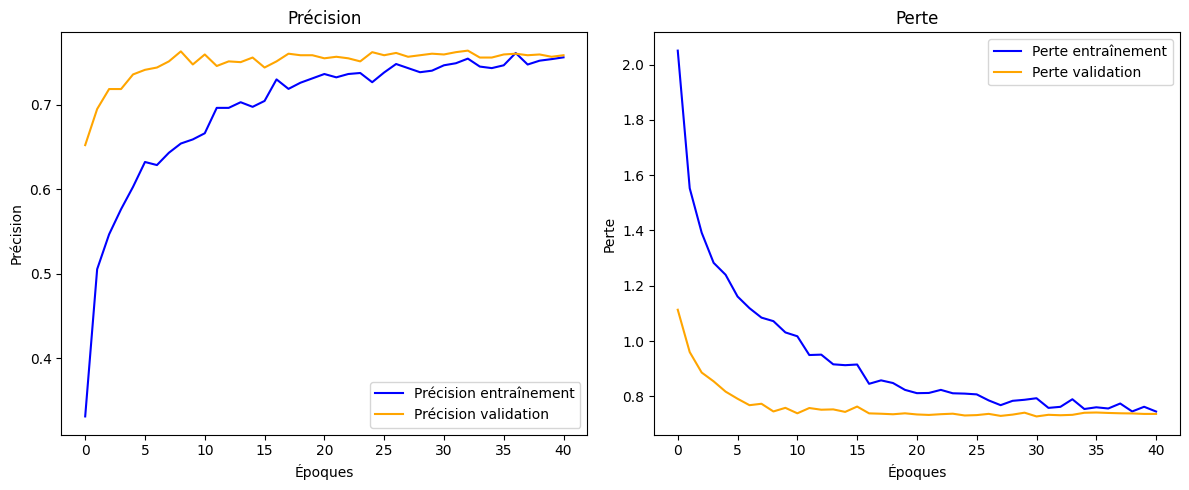

In [11]:
import matplotlib.pyplot as plt
# Précision
# Visualisation des courbes d'apprentissage
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision entraînement')
plt.plot(epochs, val_acc, 'orange', label='Précision validation')
plt.title("Précision")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte entraînement')
plt.plot(epochs, val_loss, 'orange', label='Perte validation')
plt.title("Perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Évaluation du modèle
test_generator = val_datagen.flow_from_directory(
    os.path.join(output_dir, "test"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

model.load_weights('best_model.keras')  # Charger le meilleur modèle
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

Found 1103 images belonging to 12 classes.
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.7933 - loss: 0.7081
Test Accuracy: 0.7978241443634033


In [14]:

# Sauvegarder le modèle entier
model.save('/content/split_dataset/modele_agricultural_pests.h5')
print("Modèle sauvegardé avec succès !")


Modèle sauvegardé avec succès !


In [15]:
from google.colab import files

# Télécharger le fichier sauvegardé sur votre ordinateur
files.download('/content/split_dataset/modele_agricultural_pests.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy('/content/split_dataset/modele_agricultural_pests.h5', '/content/drive/MyDrive/modele_agricultural_pests.h5')
print("Modèle sauvegardé dans Google Drive avec succès !")


Mounted at /content/drive
Modèle sauvegardé dans Google Drive avec succès !
